In [1]:
import sys

sys.path.append("../")

In [2]:
import cv2
import ipywidgets as widgets

from src.environments import ea
from src.wrappers import PlotEpisode

math_op.py: module Numba is not installed. Install it if you want speed up correlation calculations


[INFO    ] : : beam.py: module NUMBA is not installed. Install it to speed up calculation
[INFO    ] : : : : : : : : high_order.py: module NUMBA is not installed. Install it to speed up calculation
[INFO    ] radiation_py.py: module NUMBA is not installed. Install it to speed up calculation
[INFO    ] radiation_py.py: module NUMBA is not installed. Install it to speed up calculation
[INFO    ] csr.py: module NUMBA is not installed. Install it to speed up calculation
[INFO    ] csr.py: module PYFFTW is not installed. Install it to speed up calculation.
[INFO    ] csr.py: module NUMEXPR is not installed. Install it to speed up calculation
[INFO    ] wake3D.py: module NUMBA is not installed. Install it to speed up calculation


initializing ocelot...
import: module NUMBA is not installed. Install it to speed up calculation
import: module PYFFTW is not installed. Install it to speed up calculation
import: module NUMEXPR is not installed. Install it to speed up calculation


In [3]:
env = ea.TransverseTuning(
    backend="cheetah",
    action_mode="direct",
    magnet_init_mode=None,
    render_mode="rgb_array",
    backend_args={"generate_screen_images": True},
)
env = PlotEpisode(env, save_dir="../plots", episode_trigger=lambda _: True)

Overwriting existing episode plots at /Users/jankaiser/Documents/DESY/ares-transverse-tuning/plots folder. Specify a different `save_dir` for the `RecordEpisode` wrapper if this is not desired.


BoundedFloatText(value=0.0, description='AREAMQZM1', max=72.0, min=-72.0)

BoundedFloatText(value=0.0, description='AREAMQZM2', max=72.0, min=-72.0)

BoundedFloatText(value=0.0, description='AREAMCVM1', max=6178199552.0, min=-6178199552.0)

BoundedFloatText(value=0.0, description='AREAMQZM3', max=72.0, min=-72.0)

BoundedFloatText(value=0.0, description='AREAMCHM1', max=6178199552.0, min=-6178199552.0)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x03>\x00\x00\x01\xfe\x08\x02\x00\x00\x00\xd2\xdeL\x1…

Button(description='Done!', style=ButtonStyle())

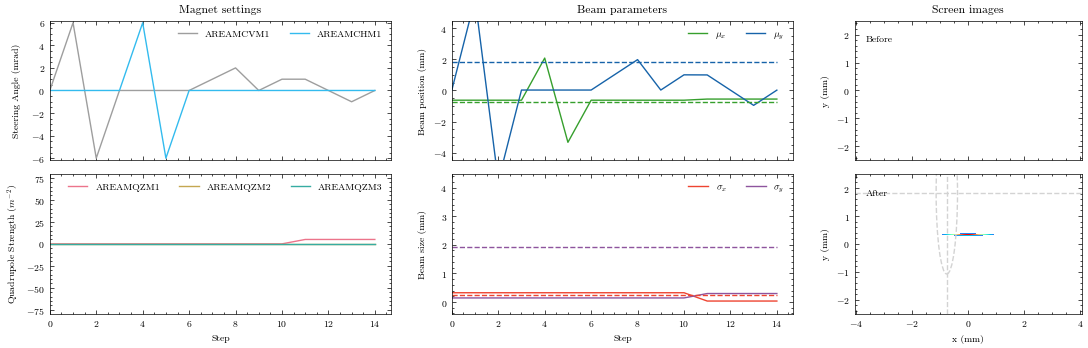

In [7]:
observation, info = env.reset()

magnet_names = info["magnet_names"]
magnet_mins = env.observation_space["magnets"].low
magnet_maxs = env.observation_space["magnets"].high
current_magnet_settings = observation["magnets"]

magnet_mins[2] = magnet_mins[2] * 1e3
magnet_mins[4] = magnet_mins[4] * 1e3
magnet_maxs[2] = magnet_maxs[2] * 1e3
magnet_maxs[4] = magnet_maxs[4] * 1e3
current_magnet_settings[2] = current_magnet_settings[2] * 1e3
current_magnet_settings[4] = current_magnet_settings[4] * 1e3

image = env.render()

magnet_widgets = [
    widgets.BoundedFloatText(
        value=setting, description=name, min=min_limit, max=max_limit
    )
    for name, min_limit, max_limit, setting in zip(
        magnet_names, magnet_mins, magnet_maxs, current_magnet_settings
    )
]
for w in magnet_widgets:
    w.observe(lambda _: update_screen_image(), names="value")

done_button = widgets.Button(description="Done!")
done_button.on_click(lambda _: on_done_button_clicked())

bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
_, buffer = cv2.imencode(".png", bgr)
screen_image_widget = widgets.Image(value=buffer, format="png", width=500, height=500)

display(*magnet_widgets, screen_image_widget, done_button)


def update_screen_image():
    action = [widget.value for widget in magnet_widgets]
    action[2] = action[2] * 1e-3
    action[4] = action[4] * 1e-3
    observation, _, _, _, _ = env.step(action)

    for i, (w, setting) in enumerate(zip(magnet_widgets, observation["magnets"])):
        if i == 2 or i == 4:
            w.value = setting * 1e3
        else:
            w.value = setting

    image = env.render()
    bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    _, buffer = cv2.imencode(".png", bgr)
    screen_image_widget.value = buffer


def on_done_button_clicked():
    env.close()
    for w in magnet_widgets:
        w.close()
    screen_image_widget.close()
    done_button.close()